In [2]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp, bases_poly_2D_s_a_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [3]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [4]:
def reward(traj_mat, act_mat):
    # traj_mat shape: (m, I, dim)
    # act_mat shape: (m, I, dim)
    # output shape: (m, I, 1)
    r_1 = torch.einsum("ijk,kl,ijl->ij", traj_mat, Q, traj_mat)
    r_2 = torch.einsum("ijk,kl,ijl->ij", act_mat, R, act_mat)
    return (- r_1 - r_2).unsqueeze(-1)

In [23]:
beta = 1e-2
A =  0.5 * torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = torch.tensor([[0.6, 0.8], [0.8, -0.6]])
B = torch.tensor([[1, 0.1], [0.1, 1.01]])
sig = 1
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [24]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(3.3742)


In [25]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [26]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [27]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.3978,  0.1247],
        [ 0.1155, -0.5830]])
tensor([[0.],
        [0.]])
tensor([-8.7093e+01, -4.2647e-01,  3.4674e-02, -4.4447e-01])
tensor([-1.4909e+02, -1.0383e+00, -5.0889e-02, -4.5259e-01])


In [28]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = False
deterministic = True
b_val_phibe, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


In [29]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = False
deterministic = True
b_val_phibe, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]

infeasibility detected


In [30]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


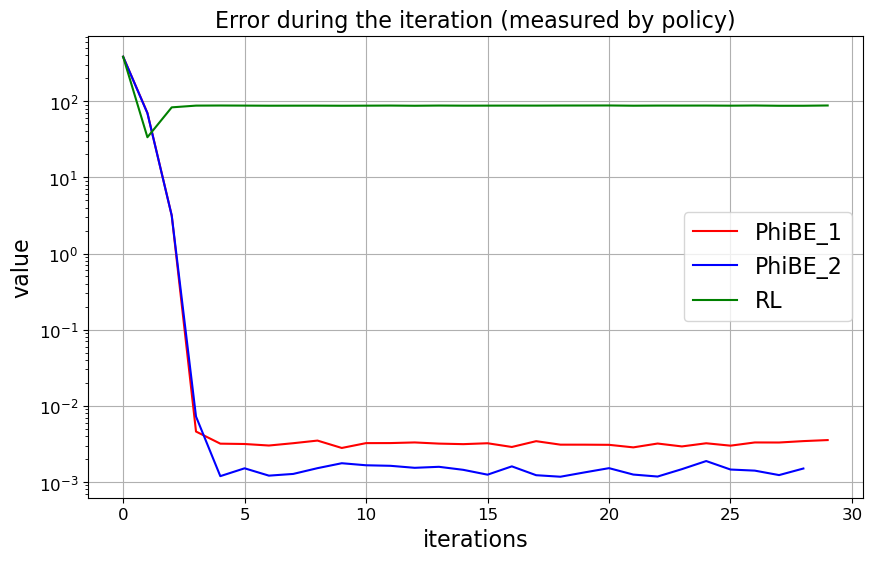

In [31]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [32]:
beta = 0.01
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = 1 * torch.inverse(torch.tensor([[.4, 0.2], [0.2, 0.4]]))
# A = torch.tensor([[1.5, 0.6], [0.6, 1.8]])
# B = torch.tensor([[0.4, 0.2], [0.2, 0.6]])
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [33]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [34]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [35]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [36]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.1330,  0.0256],
        [ 0.0112, -0.2104]])
tensor([[0.],
        [0.]])
tensor([-55.4728,  -0.2810,   0.0794,  -0.2737])
tensor([-231.8725,   -1.2978,    1.6858,   -1.0209])


In [38]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


In [39]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


In [40]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


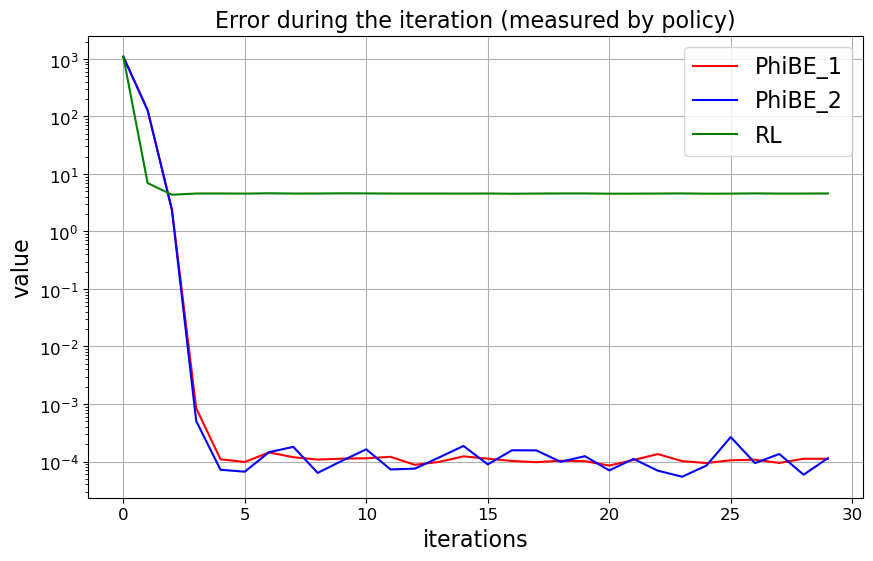

In [41]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [42]:
beta = 0.01
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A =  0.5 * torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = torch.tensor([[0.6, 0.8], [0.8, -0.6]])
B = torch.tensor([[1, 0.1], [0.1, 1.01]])
# A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
# B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
Q = 1 * torch.inverse(torch.tensor([[.4, 0.35], [0.35, 0.4]]))
R = 1 * torch.tensor([[0.9, 0.85], [0.85, 0.9]])
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [43]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(3.3742)


In [44]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(210000.0000)


In [45]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 0.5 * torch.randn(2, 2)
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [46]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-9.8036,  9.5108],
        [ 9.5085, -9.8090]])
tensor([[0.],
        [0.]])
tensor([-153.7039,   -0.7661,    0.5973,   -0.7709])
tensor([-159.3620,   -0.7977,    0.5424,   -0.7959])


In [47]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:   7%|▋         | 2/30 [00:03<00:43,  1.56s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  47%|████▋     | 14/30 [00:20<00:22,  1.41s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


In [48]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


In [49]:
bd_low_s = -5
bd_upper_s = 5
bd_low_a = -10
bd_upper_a = 10
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


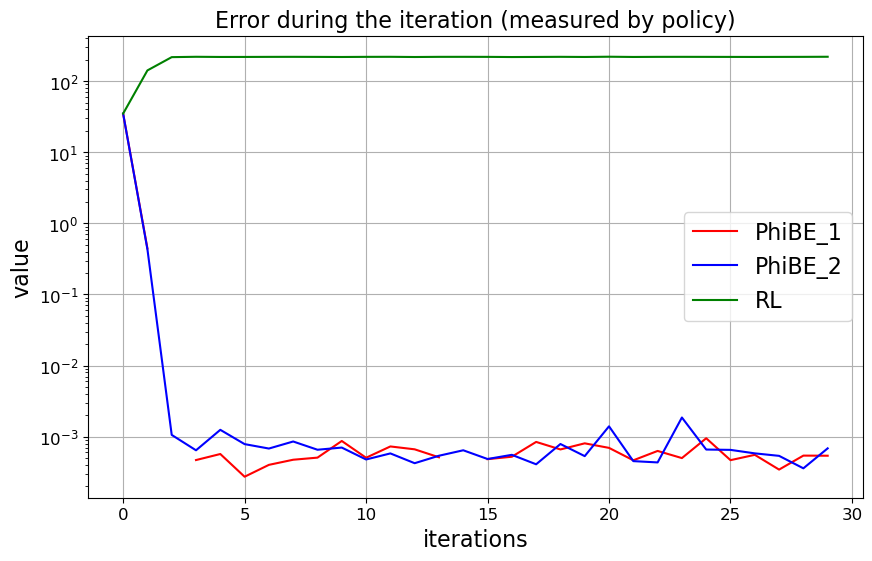

In [50]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [64]:
beta = 0.01
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
B = 1 * torch.tensor([[0.9, 0.85], [0.85, 0.88]])
A = 1 * torch.inverse(torch.tensor([[.4, 0.35], [0.35, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 1
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [65]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(327222.7078)


In [66]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [67]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 100 * torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [68]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-493.9887,  492.4366],
        [ 509.8068, -512.2836]])
tensor([[0.],
        [0.]])
tensor([-1748638.8599,    -8741.5737,    17483.5034,    -8744.8149])
tensor([-1787371.6547,    -9007.1667,    17825.5666,    -8866.5499])


In [69]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


In [74]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


In [81]:
bd_low_s = -500
bd_upper_s = 500
bd_low_a = - 600
bd_upper_a = 600
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:  77%|███████▋  | 23/30 [00:26<00:08,  1.15s/it]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


In [83]:
b_val_RL

[tensor([[-419.0175,  354.7649],
         [ 628.2385, -686.8419]]),
 tensor([[-441.1748,  420.8998],
         [ 516.7101, -560.6849]]),
 tensor([[-446.6725,  435.7144],
         [ 474.6131, -496.6491]]),
 tensor([[-444.2550,  437.8475],
         [ 471.5362, -482.5624]]),
 tensor([[-440.9715,  437.3557],
         [ 474.9068, -480.9186]]),
 tensor([[-428.8786,  426.5867],
         [ 497.4386, -501.0476]]),
 tensor([[-439.6845,  438.2210],
         [ 479.2047, -481.8013]]),
 tensor([[-399.0129,  397.5530],
         [ 582.8356, -585.1423]]),
 tensor([[-530.6924,  529.1739],
         [ 458.0435, -460.3799]]),
 tensor([[-520.7760,  518.8604],
         [ 365.0132, -367.9931]]),
 tensor([[-466.7605,  464.8877],
         [ 690.3776, -692.8416]]),
 tensor([[-413.9489,  412.6592],
         [ 563.8381, -565.9383]]),
 tensor([[-390.1133,  387.0833],
         [ 565.2910, -570.2575]]),
 tensor([[-474.9328,  473.6858],
         [ 482.9898, -486.7342]]),
 tensor([[-420.6463,  419.0128],
         [ 531.

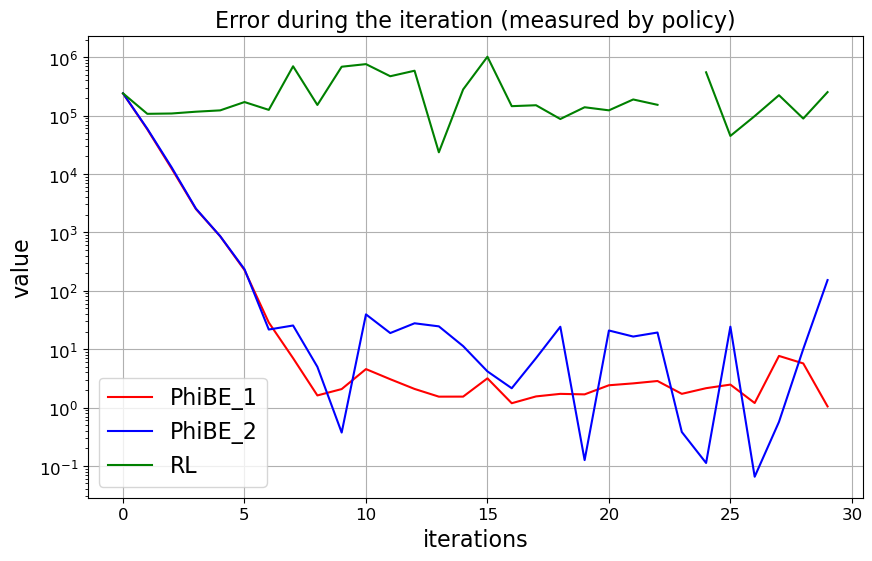

In [84]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [82]:
b_val_phibe_1

[tensor([[-419.0175,  354.7649],
         [ 628.2385, -686.8419]]),
 tensor([[-478.4192,  458.2868],
         [ 562.0593, -609.5143]]),
 tensor([[-489.6562,  478.4327],
         [ 522.5893, -546.0690]]),
 tensor([[-494.5912,  488.1681],
         [ 509.7679, -521.5801]]),
 tensor([[-495.2947,  491.5377],
         [ 507.8639, -514.1521]]),
 tensor([[-494.6803,  492.3140],
         [ 508.8739, -512.6752]]),
 tensor([[-494.1862,  492.3886],
         [ 509.6784, -512.5471]]),
 tensor([[-494.0692,  492.3994],
         [ 509.8634, -512.5232]]),
 tensor([[-493.9578,  492.3962],
         [ 510.0444, -512.5330]]),
 tensor([[-493.9445,  492.4050],
         [ 510.0656, -512.5156]]),
 tensor([[-494.0492,  492.4038],
         [ 509.8988, -512.5188]]),
 tensor([[-494.0283,  492.4025],
         [ 509.9287, -512.5171]]),
 tensor([[-494.0197,  492.4097],
         [ 509.9448, -512.5066]]),
 tensor([[-493.9634,  492.3952],
         [ 510.0336, -512.5328]]),
 tensor([[-493.9614,  492.3959],
         [ 510.